In [0]:
!pip install tqdm  >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from bert import tokenization
from tqdm import tqdm_notebook

2.2.0-rc2


In [0]:
from google.colab import files
uploaded = files.upload()

Saving EP1.csv to EP1.csv


In [0]:
import pandas as pd
df = pd.read_csv('EP1.csv')
df.head()

,Unnamed: 0,prescription,specialty
0,3490,peg with flavor packs trilyte with flavor pac...,gastroenterology
1,2584,crestor allopurinol benazepril hcl amiodaro...,cardiovasculardisease
2,7218,zoloft escitalopram oxalate cymbalta fluoxe...,psychiatry
3,10179,dexamethasone tacrolimus rapamune oxycodone...,hematologyoncology
4,1869,xifaxan omeprazole promethazine hcl prevaci...,gastroenterology


In [0]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


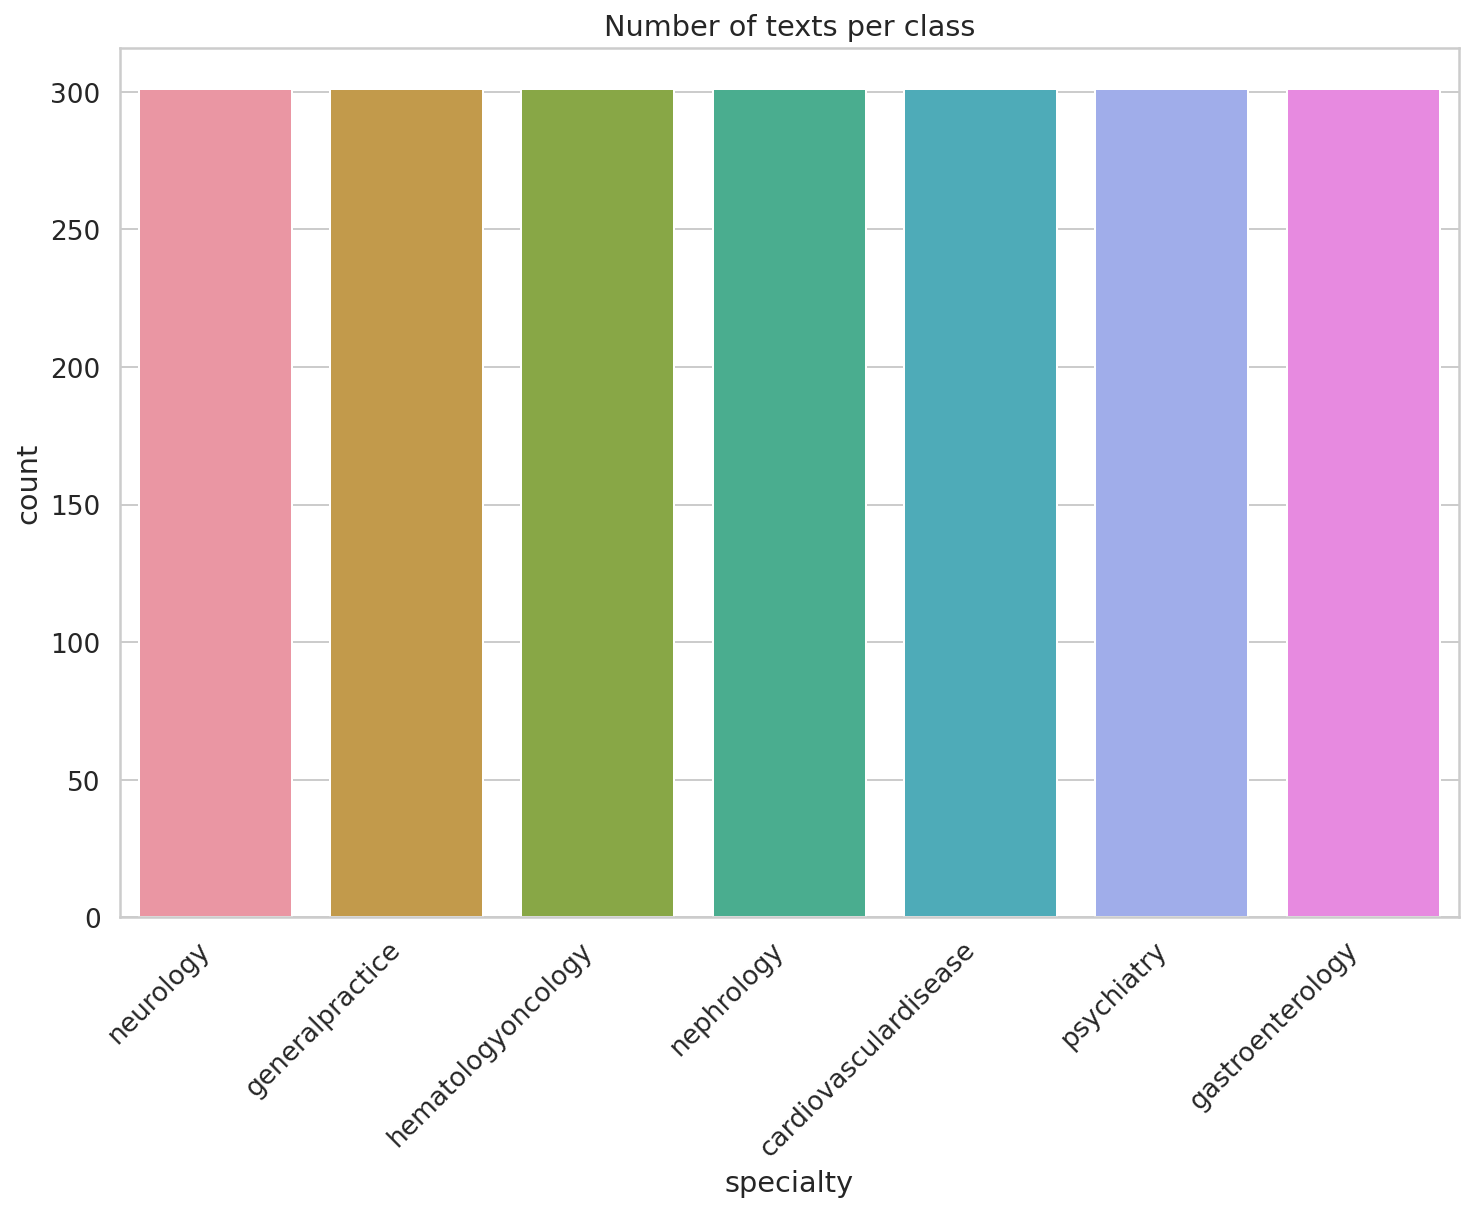

In [0]:
chart = sns.countplot(df.specialty)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-01 08:05:19--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   130MB/s    in 3.0s    

2020-04-01 08:05:22 (130 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [0]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model", exist_ok=True)

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [0]:
class PrescriptionClassification:
  DATA_COLUMN = "prescription"
  LABEL_COLUMN = "specialty"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=256):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[PrescriptionClassification.DATA_COLUMN], row[PrescriptionClassification.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [0]:
df.loc[2].prescription

'zoloft  escitalopram oxalate  cymbalta  fluoxetine hcl  venlafaxine hcl er  nortriptyline hcl  citalopram hbr  zolpidem tartrate  lamotrigine  alprazolam  methylphenidate er'

In [0]:
tokenizer.tokenize(df.loc[2].prescription)

['z',
 '##olo',
 '##ft',
 'es',
 '##cit',
 '##alo',
 '##pr',
 '##am',
 'ox',
 '##ala',
 '##te',
 'cy',
 '##mba',
 '##lta',
 'flu',
 '##ox',
 '##eti',
 '##ne',
 'hc',
 '##l',
 've',
 '##nl',
 '##af',
 '##ax',
 '##ine',
 'hc',
 '##l',
 'er',
 'nor',
 '##trip',
 '##ty',
 '##line',
 'hc',
 '##l',
 'ci',
 '##tal',
 '##op',
 '##ram',
 'h',
 '##br',
 'z',
 '##ol',
 '##pid',
 '##em',
 'tar',
 '##tra',
 '##te',
 'lam',
 '##ot',
 '##ri',
 '##gin',
 '##e',
 'al',
 '##pr',
 '##az',
 '##ola',
 '##m',
 'methyl',
 '##ph',
 '##eni',
 '##date',
 'er']

In [0]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=64, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [0]:
df = df.sample(frac=1)
classes = df.specialty.unique().tolist()

data = PrescriptionClassification(df[:int(len(df)*.8)], df[int(len(df)*.8):], tokenizer, classes, max_seq_len=153)

1685it [00:01, 1049.07it/s]
422it [00:00, 1037.97it/s]

max seq_len 153


In [0]:
data.train_x[500]

array([  101, 22822, 20738, 26754,  9413, 18479,  3597,  5280,  5243,
        3401, 15464,  5740,  8458,  2368,  8292,  2571, 13578,  2595,
        4372, 11636, 22068,  6657, 13365, 23060,  2100,  8663,  7629,
       23060,  2100,  3597,  5280,  2063, 16731,  2140,  6728,  5162,
        9413,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
data.train_y[500]

2

In [0]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 153, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f50ee250c50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 153)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 153, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455   

In [0]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [0]:
log_dir = "log/prescription_classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  verbose = 1,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
48/48 [==============================] - 2409s 50s/step - loss: 1.9261 - acc: 0.1920 - val_loss: 1.7908 - val_acc: 0.5148
Epoch 2/10
48/48 [==============================] - 2398s 50s/step - loss: 1.7838 - acc: 0.3806 - val_loss: 1.4917 - val_acc: 0.7337
Epoch 3/10
48/48 [==============================] - 2420s 50s/step - loss: 1.5548 - acc: 0.6517 - val_loss: 1.3689 - val_acc: 0.8225
Epoch 4/10
48/48 [==============================] - 2419s 50s/step - loss: 1.3862 - acc: 0.8219 - val_loss: 1.2418 - val_acc: 0.9172
Epoch 5/10
48/48 [==============================] - 2420s 50s/step - loss: 1.2872 - acc: 0.9109 - val_loss: 1.2147 - val_acc: 0.9527
Epoch 6/10
48/48 [==============================] - 2413s 50s/step - loss: 1.2442 - acc: 0.9426 - val_loss: 1.2195 - val_acc: 0.9527
Epoch 7/10
48/48 [==============================] - 2406s 50s/step - loss: 1.2212 - acc: 0.9617 - val_loss: 1.2012 - val_acc: 0.9586
Epoch 8/10
48/48 [==============================] - 2407s 50s/step - 

In [0]:
log_dir = "log/prescription_classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  verbose = 1,
  callbacks=[tensorboard_callback]
)

In [0]:
_,testacc = model.evaluate(data.test_x, data.test_y)

14/14 [==============================] - 196s 14s/step - loss: 1.1981 - acc: 0.9645


In [0]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [0]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        68
           1       1.00      0.98      0.99        55
           2       0.97      1.00      0.98        56
           3       0.98      0.94      0.96        63
           4       0.96      1.00      0.98        64
           5       0.88      1.00      0.94        59
           6       0.98      0.98      0.98        57

    accuracy                           0.96       422
   macro avg       0.97      0.97      0.97       422
weighted avg       0.97      0.96      0.96       422



In [0]:
confusion_matrix(data.test_y, y_pred)

array([[59,  0,  1,  0,  0,  8,  0],
       [ 0, 54,  0,  1,  0,  0,  0],
       [ 0,  0, 56,  0,  0,  0,  0],
       [ 0,  0,  1, 59,  2,  0,  1],
       [ 0,  0,  0,  0, 64,  0,  0],
       [ 0,  0,  0,  0,  0, 59,  0],
       [ 0,  0,  0,  0,  1,  0, 56]])

In [0]:
data.test_x[:10]

array([[  101, 10975,  8447, ...,     0,     0,     0],
       [  101, 11163, 21748, ...,     0,     0,     0],
       [  101, 15544, 17668, ...,     0,     0,     0],
       ...,
       [  101, 18856,  7856, ...,     0,     0,     0],
       [  101,  8823,  3630, ...,     0,     0,     0],
       [  101, 14418, 27753, ...,     0,     0,     0]])

In [0]:
data.test_y[:10]

array([4, 4, 5, 6, 4, 3, 0, 0, 4, 6])

In [0]:
print(classes.index('nephrology'))
print(classes.index('neurology'))
print(classes.index('gastroenterology'))
print(classes.index('cardiovasculardisease'))
print(classes.index('psychiatry'))
print(classes.index('hematologyoncology'))
print(classes.index('generalpractice'))

3
0
6
4
5
2
1


In [0]:
model.save()

In [0]:
prescriptions = [
  "prazosin hcl  clozapine  clonazepam  buspirone hcl  quetiapine fumarate  amphetamine salt combo  gabapentin  cymbalta  venlafaxine hcl er  levothyroxine sodium  lithium carbonate  lamotrigine  dextroamphetamine sulfate  zolpidem tartrate  abilify  topiramate", #psychiatry
  "sertraline hcl  gabapentin  omeprazole  clopidogrel  amlodipine besylate  fluticasone propionate  carvedilol  atorvastatin calcium  lisinopril", #cardiovascular
  "anastrozole  hydroxyurea  exemestane  allopurinol  letrozole  acyclovir  tasigna  prednisone", #hematology
  "gabapentin  pyridostigmine bromide  carbidopalevodopa  glycopyrrolate  amitriptyline hcl  lamotrigine  namenda  donepezil hcl  carbidopalevodopa er  levetiracetam", #neurology
  "amoxicillin" #generalpractice
]

pred_tokens = map(tokenizer.tokenize, prescriptions)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nspecialty:", classes[label])
  print()


text: prazosin hcl  clozapine  clonazepam  buspirone hcl  quetiapine fumarate  amphetamine salt combo  gabapentin  cymbalta  venlafaxine hcl er  levothyroxine sodium  lithium carbonate  lamotrigine  dextroamphetamine sulfate  zolpidem tartrate  abilify  topiramate 
specialty: psychiatry

text: sertraline hcl  gabapentin  omeprazole  clopidogrel  amlodipine besylate  fluticasone propionate  carvedilol  atorvastatin calcium  lisinopril 
specialty: cardiovasculardisease

text: anastrozole  hydroxyurea  exemestane  allopurinol  letrozole  acyclovir  tasigna  prednisone 
specialty: hematologyoncology

text: gabapentin  pyridostigmine bromide  carbidopalevodopa  glycopyrrolate  amitriptyline hcl  lamotrigine  namenda  donepezil hcl  carbidopalevodopa er  levetiracetam 
specialty: neurology

text: amoxicillin 
specialty: generalpractice



In [1]:
#4 right 0 wrong

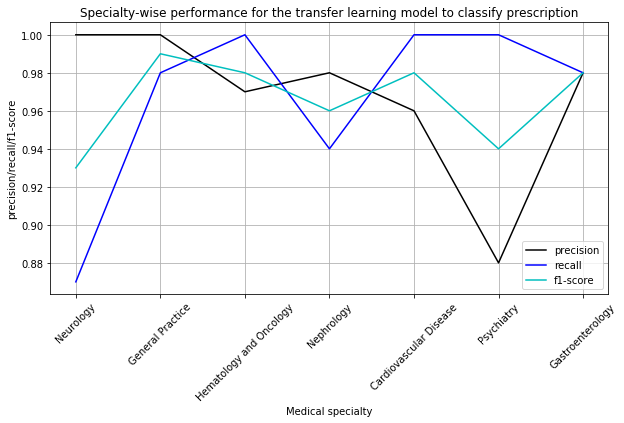

In [3]:
#transfer learning
import matplotlib.pyplot as plt
label = ['Neurology', 'General Practice', 'Hematology and Oncology', 'Nephrology', 'Cardiovascular Disease', 
          'Psychiatry', 'Gastroenterology']
precision = [1.0, 1.0, 0.97, 0.98, 0.96, 0.88, 0.98]
recall = [0.87, 0.98, 1.0, 0.94 ,1.0, 1.0, 0.98]
f1 = [0.93 , 0.99, 0.98, 0.96, 0.98, 0.94, 0.98]
plt.figure(figsize=(10, 5))
plt.xticks([0, 1, 2, 3, 4, 5, 6],label, fontsize=10, rotation=45)
plt.plot(precision, color='k', label = 'precision')
plt.plot(recall, color='b', label = 'recall')
plt.plot( f1, color='c', label = 'f1-score')
plt.legend()
plt.xlabel('Medical specialty')
plt.ylabel('precision/recall/f1-score')
plt.title('Specialty-wise performance for the transfer learning model to classify prescription')
plt.grid()
plt.show()